# Project : Brain Tumor Detection

By observing the MRI Scanning of the brain , we can predict whether there is tumor or not for a person and we can label the tumor type also.<br>
We can take precautions like early treatment which improves survival rates.

## 1.Import the essential libraries

In [2]:
import numpy as np # numpy is used to deal with numerical representation of images
import pandas as pd # for data manipulation
import os # for locating files in the drive and work with them
import matplotlib.pyplot as plt # for visualising the data such as images and plots of accuracy ,loss
from sklearn.utils import shuffle
import random
from PIL import Image,ImageEnhance
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Activation,LeakyReLU,ReLU
from tensorflow.keras.layers import Dense,Flatten,Dropout,BatchNormalization,Input
import cv2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score,recall_score,classification_report

## 2.Data Gathering

In [3]:
# connecting notebook to Drive , so we can access dataset in the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train_dir = '/content/drive/MyDrive/Medical-Image-Analysis-Brain-Tumor-Detection-main (1)/Brain_Tumor/Training'
# print(os.listdir(train_dir)) # for checking
test_dir = '/content/drive/MyDrive/Medical-Image-Analysis-Brain-Tumor-Detection-main (1)/Brain_Tumor/Testing'
print(os.listdir(test_dir))

['no_tumor', 'glioma_tumor', 'meningioma_tumor', 'pituitary_tumor']


In [5]:
# load and shuffle the training data
train_paths = []
train_labels = []

for label in os.listdir(train_dir):
  for img in os.listdir(os.path.join(train_dir,label)):
    train_paths.append(os.path.join(train_dir,label,img))
    train_labels.append(label)

# shuffle
train_paths,train_labels = shuffle(train_paths,train_labels)
print('Loading and shuffling of training data is completed')

Loading and shuffling of training data is completed


In [6]:
# load and shuffle test data
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
  for img in os.listdir(os.path.join(test_dir,label)):
    test_paths.append(os.path.join(test_dir,label,img))
    test_labels.append(label)
test_paths,test_labels = shuffle(test_paths,test_labels)
print('Loading and shuffling of testing data is completed')


Loading and shuffling of testing data is completed


## 3.Data Visualisation

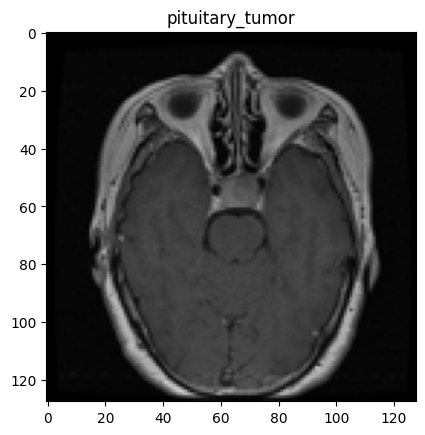

In [7]:
# let's take one random photo and label from the training data
random_index  = random.randint(0,len(train_paths))
img_path = train_paths[random_index]
img_label = train_labels[random_index]

img = Image.open(img_path)
img = img.resize((128,128))
plt.title(img_label)
plt.imshow(img)
plt.show()

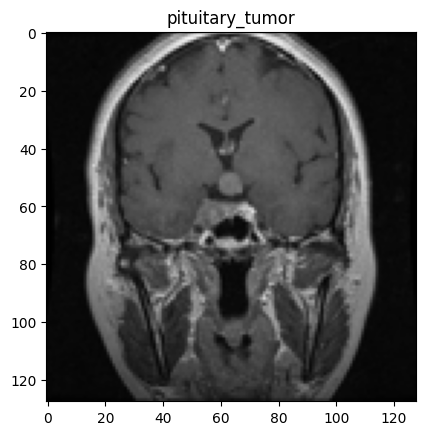

In [8]:
# Visulaize one image from the  test data
random_index  = random.randint(0,len(test_paths))
img_path = test_paths[random_index]
img_label = test_labels[random_index]

img = Image.open(img_path)
img = img.resize((128,128))
plt.title(img_label)
plt.imshow(img)
plt.show()

## 4.Data Preprocessing

In [9]:
IMG_SIZE = 224

In [10]:
def augument_image(image):
  image = Image.fromarray(np.uint8(image))
  image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2)) # for random brightness
  image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2)) # random contrast
  image = np.array(image)/255.0
  return image

# open images and apply augumentation
def open_images(paths):
  images = []
  for path in paths:
    image = load_img(path,target_size=(IMG_SIZE,IMG_SIZE))
    image = augument_image(image)
    images.append(image)
  return np.array(images)

# encode the labels
def encode_labels(labels):
  unique_labels = os.listdir(train_dir)
  encoded = [unique_labels.index(label) for label in labels]
  return np.array(encoded)

# Data Generator for batching ,because model takes lot of time to train on full data
def datagen(paths,labels,batch_size=12,epochs=5):
  # number of times the  model trains  on whole data
  for _ in range(epochs):
    for i in range(0,len(paths),batch_size):
      batch_paths = paths[i:i+batch_size]
      batch_images = open_images(batch_paths)
      batch_labels = labels[i:i+batch_size]
      batch_labels = encode_labels(batch_labels)
      # yield : not returning just give batch to train after that another batch is given saves memory
      yield batch_images,batch_labels

## 4.Model Building

In [ ]:
# let's build a simple model

model = Sequential([
    # block1
   Conv2D(12,3,input_shape=(IMG_SIZE,IMG_SIZE,3),activation='relu'),
   MaxPooling2D(pool_size=(2,2)),
   Conv2D(18,3,activation='relu'),
   MaxPooling2D(pool_size=(2,2)),
   Flatten(),
   Dropout(0.3),
   Dense(64),
   Dropout(0.3),
   Dense(32),
   Dense(4,activation='softmax')

])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 12)   │           336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 18)     │         1,962 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 18)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 16200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │     1,036,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,041,374 (3.97 MB)

 Trainable params: 1,041,374 (3.97 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# compile the model
model.compile(optimizer=Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])

In [ ]:
# parameters
batch_size = 24
steps = int(np.ceil(len(train_paths)/batch_size)) # number of batches processed in one epoch
epochs = 5
history = model.fit(datagen(train_paths,train_labels,batch_size=24,epochs=5),steps_per_epoch=steps,epochs=epochs)

Epoch 1/5
120/120 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - loss: 1.3942 - sparse_categorical_accuracy: 0.4959
Epoch 2/5
120/120 ━━━━━━━━━━━━━━━━━━━━ 43s 358ms/step - loss: 0.5865 - sparse_categorical_accuracy: 0.7563
Epoch 3/5
120/120 ━━━━━━━━━━━━━━━━━━━━ 43s 358ms/step - loss: 0.4045 - sparse_categorical_accuracy: 0.8386
Epoch 4/5
120/120 ━━━━━━━━━━━━━━━━━━━━ 40s 335ms/step - loss: 0.3196 - sparse_categorical_accuracy: 0.8798
Epoch 5/5
120/120 ━━━━━━━━━━━━━━━━━━━━ 41s 344ms/step - loss: 0.2589 - sparse_categorical_accuracy: 0.9051


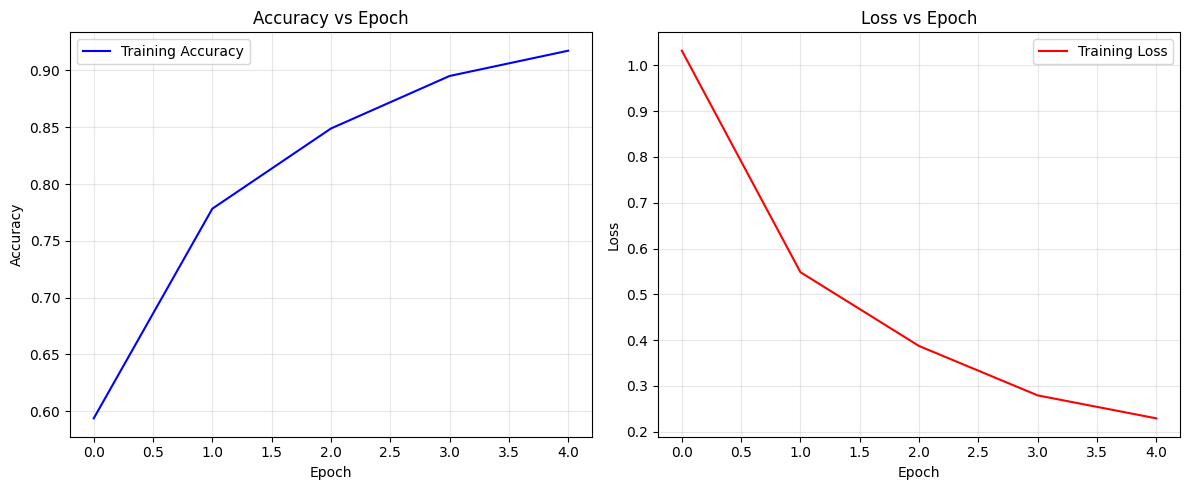

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Left subplot: Accuracy
ax1.plot(history.history['sparse_categorical_accuracy'], 'b-', label='Training Accuracy')
ax1.set_title('Accuracy vs Epoch')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right subplot: Loss
ax2.plot(history.history['loss'], 'r-', label='Training Loss')
ax2.set_title('Loss vs Epoch')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
test_pred = model.predict(open_images(test_paths))
test_pred = np.argmax(test_pred,axis=1) # it is used to take the high probability class where softmax returns 4 probabilities
test_labels = encode_labels(test_labels)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step


In [ ]:
print(classification_report(test_labels,test_pred))

              precision    recall  f1-score   support

           0       0.19      0.19      0.19        80
           1       0.27      0.29      0.28        80
           2       0.27      0.33      0.30        80
           3       0.19      0.14      0.16        80

    accuracy                           0.23       320
   macro avg       0.23      0.23      0.23       320
weighted avg       0.23      0.23      0.23       320



Model does not works well , so let's try using transfer learning

VGG16

In [11]:
base_model = VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

for layer in base_model.layers:
    layer.trainable = False
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential([
  Input((IMG_SIZE,IMG_SIZE,3)),
  base_model,
  Flatten(),
  Dropout(0.3),
  Dense(128,activation='relu'),
  Dropout(0.2),
  Dense(64,activation='relu'),
  Dropout(0.2),
  Dense(4,activation='softmax')
])


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [12]:
# compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="sparse_categorical_crossentropy",  # because labels are integers
    metrics=["accuracy"]
)

In [13]:
epochs = 5
batch_size = 24
steps = int(np.ceil(len(train_paths)/batch_size))
history = model.fit(datagen(train_paths,train_labels,batch_size,epochs=epochs),steps_per_epoch=steps,epochs=epochs)

Epoch 1/5
120/120 ━━━━━━━━━━━━━━━━━━━━ 1283s 11s/step - accuracy: 0.5541 - loss: 1.0361
Epoch 2/5
120/120 ━━━━━━━━━━━━━━━━━━━━ 24s 202ms/step - accuracy: 0.8120 - loss: 0.4896
Epoch 3/5
120/120 ━━━━━━━━━━━━━━━━━━━━ 24s 199ms/step - accuracy: 0.8763 - loss: 0.3235
Epoch 4/5
120/120 ━━━━━━━━━━━━━━━━━━━━ 24s 197ms/step - accuracy: 0.9056 - loss: 0.2482
Epoch 5/5
120/120 ━━━━━━━━━━━━━━━━━━━━ 24s 197ms/step - accuracy: 0.9466 - loss: 0.1675


## Model Evaluation

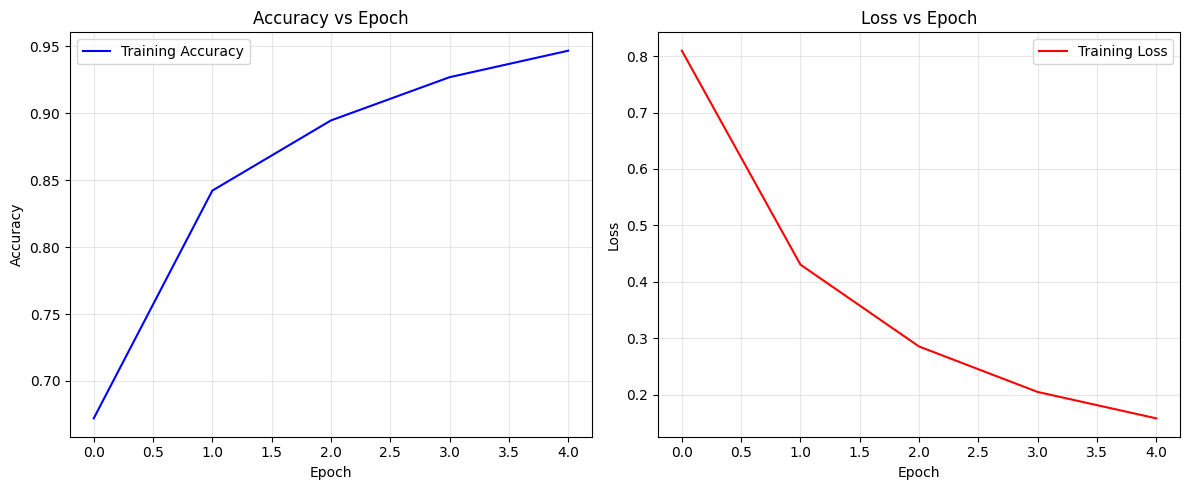

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Left subplot: Accuracy
ax1.plot(history.history['accuracy'], 'b-', label='Training Accuracy')
ax1.set_title('Accuracy vs Epoch')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right subplot: Loss
ax2.plot(history.history['loss'], 'r-', label='Training Loss')
ax2.set_title('Loss vs Epoch')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [16]:
test_pred = model.predict(open_images(test_paths))
test_pred = np.argmax(test_pred,axis=1) # it is used to take the high probability class where softmax returns 4 probabilities
test_labels = encode_labels(test_labels)

10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 161ms/step


In [17]:
print(classification_report(test_labels,test_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        80
           1       0.98      1.00      0.99        80
           2       1.00      0.94      0.97        80
           3       0.93      0.99      0.96        80

    accuracy                           0.97       320
   macro avg       0.98      0.98      0.98       320
weighted avg       0.98      0.97      0.98       320



<Axes: >

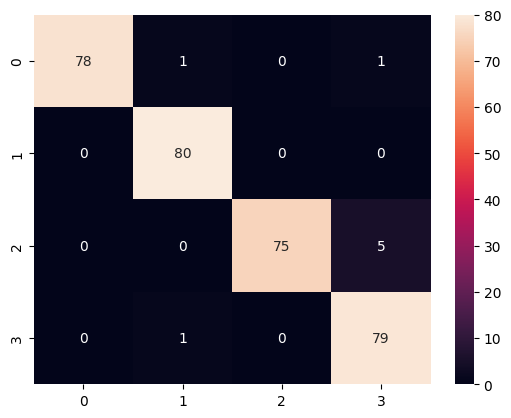

In [21]:
import seaborn as sns
sns.heatmap(confusion_matrix(test_labels,test_pred),annot=True)

In [19]:
confusion_matrix(test_labels,test_pred)

array([[78,  1,  0,  1],
       [ 0, 80,  0,  0],
       [ 0,  0, 75,  5],
       [ 0,  1,  0, 79]])

## Save Model

In [22]:
model.save('vgg_base_model.h5')

In [ ]:
from google.colab import files
files.download('vgg_base_model.h5')
